In [2]:
import torch
from torch.utils import data
import glob
import os
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

import math

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

from torch.utils.data import DataLoader
import torchvision.models as models

In [3]:
# To read the images in numerical order
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def get_video_frames(path):
        videogen = skvideo.io.vreader(path)
        frames = np.array([frame for frame in videogen])
        return frames

In [40]:
lips_filelist = sorted(glob.glob('/Users/manideepkolla/Downloads/test_fold/output/*/*.mp4'), key=numericalSort)
masks_filelist = sorted(glob.glob('/Users/manideepkolla/Downloads/test_fold/output/*/*.npy'), key=numericalSort)
spects_filelist = sorted(glob.glob('/Users/manideepkolla/Downloads/test_fold/output/*/*.png'), key=numericalSort)

In [41]:
folders_list = sorted(glob.glob('/Users/manideepkolla/Downloads/test_fold/output/*'), key=numericalSort)

In [46]:
mask = np.load(masks_filelist[0])

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x120b75b00>
Traceback (most recent call last):
  File "/Users/manideepkolla/py3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/Users/manideepkolla/py3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


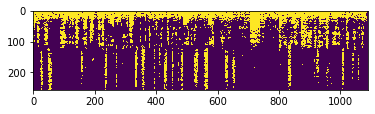

In [55]:
plt.imshow(np.rollaxis(mask, 1, 0))

In [57]:
mask.shape

(1090, 257)

In [7]:
# DataLoader class

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, lips_filelist, masks_filelist, spects_filelist):
        'Initialization'
        self.lips_filelist = lips_filelist
        self.masks_filelist = masks_filelist
        self.spects_filelist = spects_filelist

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.lips_filelist)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        lips_filename = self.lips_filelist[index]
        mask_filename = self.masks_filelist[index]
        spect_filename = self.spects_filelist[index]
        
        # Read the lips.mp4 file
        lips = get_video_frames(lip_filename)
        
        # Read mask
        mask = np.load(mask_filename)
        
        # Read mixed spectrogram
        spect = io.imread(spect_filename)

        return lips, spect, mask

In [9]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 100

In [10]:
# Generators
training_set = Dataset(lips_filelist, masks_filelist, spects_filelist)
training_generator = data.DataLoader(training_set, **params)

In [ ]:
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        [...]

    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            [...]

In [34]:
class SpeechSepModel(nn.Module):
    def __init__(self, vocab_size):
        super(SpeechSepModel, self).__init__()

        self.conv_audio = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2)),
            nn.ReLU(True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Dropout3d(0.5),
            nn.Conv3d(32, 64, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2)),
            nn.ReLU(True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Dropout3d(0.5),
            nn.Conv3d(64, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.ReLU(True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Dropout3d(0.5)
        )
        # T B C*H*W
        self.gru1 = nn.GRU(96 * 3 * 6, 256, 1, bidirectional=True)
        self.drp1 = nn.Dropout(0.5)
        # T B F
        self.gru2 = nn.GRU(256 * 2, 256, 1, bidirectional=True)
        self.drp2 = nn.Dropout(0.5)
        # T B V
        self.pred = nn.Linear(256 * 2, vocab_size + 1)
        
        # initialisations
        for m in self.conv_audio.modules():
            if isinstance(m, nn.Conv3d):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                init.constant_(m.bias, 0)

        init.kaiming_normal_(self.pred.weight, nonlinearity='sigmoid')
        init.constant_(self.pred.bias, 0)
        
        '''# Visual Processing
        
        self.visual = nn.Sequential(
            nn.)'''

        for m in (self.gru1, self.gru2):
            stdv = math.sqrt(2 / (96 * 3 * 6 + 256))
            for i in range(0, 256 * 3, 256):
                init.uniform_(m.weight_ih_l0[i: i + 256],
                            -math.sqrt(3) * stdv, math.sqrt(3) * stdv)
                init.orthogonal_(m.weight_hh_l0[i: i + 256])
                init.constant_(m.bias_ih_l0[i: i + 256], 0)
                init.uniform_(m.weight_ih_l0_reverse[i: i + 256],
                            -math.sqrt(3) * stdv, math.sqrt(3) * stdv)
                init.orthogonal_(m.weight_hh_l0_reverse[i: i + 256])
                init.constant_(m.bias_ih_l0_reverse[i: i + 256], 0)
    
    def forward(self, x):
        x = self.conv_audio(x) # B C T H W
        '''x = x.permute(2, 0, 1, 3, 4).contiguous() # T B C H W
        x = x.view(x.size(0), x.size(1), -1)
        x, _ = self.gru1(x)
        x = self.drp1(x)
        x, _ = self.gru2(x)
        x = self.drp2(x)
        x = self.pred(x)'''
        
        return x

In [35]:
SpeechSepModel(1, )

__main__.SpeechSepModel

In [20]:
resnet = models.resnet18(pretrained=True)
f = torch.nn.Sequential(*list(resnet.children())[:6])
f

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [5]:
lips_filelist = sorted(glob.glob('/Users/manideepkolla/Downloads/lrs2/mvlrs_v1/pretrain/*/*.mp4'), key=numericalSort)

In [7]:
len(lips_filelist)

93036

In [ ]:
import cv2
def compute_fps(filename):
 
    video = cv2.VideoCapture(filename);
     
    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
     
    if int(major_ver)  < 3 :
        fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
        #print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
    else :
        fps = video.get(cv2.CAP_PROP_FPS)
        #print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
     
    return fps 